In [1]:
import tensorflow as tf
print(tf.__version__)

import librosa
import IPython
import data_loader
import matplotlib.pyplot as plt
from pprint import pformat
import logging
import numpy as np
import importlib

from functools import partial
keras = tf.keras

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

importlib.reload(data_loader)
DataLoader = data_loader.DataLoader
load_config = data_loader.load_config
logger = data_loader.logger

2.0.0


In [2]:
dl = DataLoader(config='./config.json', data='../data', n_max=5)

Conv2D = keras.layers.Conv2D
Dense = keras.layers.Dense
ReLU = keras.layers.ReLU
BatchNorm = keras.layers.BatchNormalization

batch_size = 1
output_size = 256

LSTM = keras.layers.LSTM
K = keras.backend

Layer = keras.layers.Layer 
DConv = keras.layers.Conv2DTranspose

INFO:root:DataLoader initializing
INFO:root:reading lab data from ../data/soundAttGAN & ../data/soundAttGAN/koreancorpus.xlsx
INFO:root:reading hub data from ../data/KsponSpeech_01


In [26]:
dataset = tf.data.Dataset.from_generator(partial(dl.train_generator, data='hub'), output_types=tf.float32, output_shapes=dl.stft_shape).batch(1)
it = dl.train_generator(data='hub')

logger.setLevel("INFO")
for each in dataset:
    print(each)
next(it).shape


a = tf.data.Dataset.from_generator(partial(dl.train_generator, data='hub'), 
                                         output_types=tf.float32, 
                                         output_shapes=dl.stft_shape)
x_train = tf.data.Dataset.zip((a, a)).cache().batch(5)

x_train

tf.Tensor(
[[[1.9634964e+00 2.1649334e+00 3.0738199e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [1.9065773e+00 1.5931227e+00 1.8589168e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [1.2908612e+00 2.3438974e-01 3.1194982e-01 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [2.6223962e-03 6.6131693e-03 3.2389378e-03 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [2.3706201e-03 5.9061623e-03 3.1549647e-03 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [4.7344775e-03 6.4871293e-03 2.8698838e-03 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]]], shape=(1, 256, 128), dtype=float32)
tf.Tensor(
[[[2.7122933e-01 2.7292967e-01 4.9477077e-01 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [9.2925519e-02 2.7519068e-01 3.4967279e-01 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [1.1287507e-02 8.1734583e-02 1.3978525e-01 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [6.2559365e-04 1.1539799e-03 1.6010784e-04 ... 0.0000000e+00
   0.0000

<BatchDataset shapes: ((None, 256, 128), (None, 256, 128)), types: (tf.float32, tf.float32)>

In [27]:
class AutoEncoder(keras.models.Model):
    def __init__(self, **kwargs):
        super(AutoEncoder, self).__init__(**kwargs)
        
        self.act_fn = keras.layers.LeakyReLU()
        self.kernel_size = (4, 4)
        
        self.conv = [
            Conv2D(filters=32, kernel_size=self.kernel_size, strides=(2, 2), padding='same', activation=None, 
                   input_shape=dl.stft_shape),
            BatchNorm(),
            self.act_fn,
            Conv2D(filters=64, kernel_size=self.kernel_size, strides=(2, 2), padding='same', activation=None),
            BatchNorm(),
            self.act_fn,
            Conv2D(filters=128, kernel_size=self.kernel_size, strides=(2, 2), padding='same', activation=None),
            BatchNorm(),
            self.act_fn,
            Conv2D(filters=256, kernel_size=self.kernel_size, strides=(2, 2), padding='same', activation=None),
            BatchNorm(),
            self.act_fn,
            Conv2D(filters=512, kernel_size=self.kernel_size, strides=(2, 2), padding='same', activation=None),
            BatchNorm(),
            self.act_fn,
#             keras.layers.Flatten(),
#             Dense(units=output_size, activation=None), 
#             self.act_fn
        ]
        
        self.dconv = [
            # 16
            DConv(filters=512, kernel_size=self.kernel_size, strides=(2, 2), padding='same', activation=None),
            BatchNorm(),
            self.act_fn,
            # 32
            DConv(filters=256, kernel_size=self.kernel_size, strides=(2, 2), padding='same', activation=None),
            BatchNorm(),
            self.act_fn,
            # 64
            DConv(filters=128, kernel_size=self.kernel_size, strides=(2, 2), padding='same', activation=None),
            BatchNorm(),
            self.act_fn,
            
            DConv(filters=64, kernel_size=self.kernel_size, strides=(2, 2), padding='same', activation=None),
            BatchNorm(),
            self.act_fn,
            
            DConv(filters=1, kernel_size=self.kernel_size, strides=(2, 2), padding='same', activation=None),
            keras.layers.ReLU(max_value=80.0)
#             keras.layers.Activation('sigmoid')
            # 128
        ]
        
    
    def call(self, inputs, **kwargs):
        
#         if len(inputs.shape) == 3:
        inputs = tf.expand_dims(inputs, -1)
        
        for layer in self.conv:
#             print(inputs.shape)
            inputs = layer(inputs)
            
        for layer in self.dconv:
#             print(inputs.shape)
            inputs = layer(inputs)
        return inputs
    

In [42]:
dir(model)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_variable_with_custom_getter',
 '_checkpoint_dependencies',
 '_default_save_signature',
 '_deferred_dependencies',
 '_gather_saveables_for_checkpoint',
 '_handle_deferred_dependencies',
 '_list_extra_dependencies_for_serialization',
 '_list_functions_for_serialization',
 '_lookup_dependency',
 '_maybe_initialize_trackable',
 '_name_based_attribute_restore',
 '_name_based_restores',
 '_no_dependency',
 '_object_identifier',
 '_preload_simple_restoration',
 '_restore_from_checkpoint_position',
 '_self_name_based_restores',
 '_self_setattr_tracking',
 '_self_unconditional_checkpoint_dependencies',
 '_self_u

In [46]:
dir(model.signatures['serving_default'])

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_arg_keywords',
 '_build_call_outputs',
 '_call_flat',
 '_call_impl',
 '_captured_closures',
 '_captured_inputs',
 '_delayed_rewrite_functions',
 '_experimental_with_cancellation_manager',
 '_filtered_call',
 '_first_order_tape_functions',
 '_func_graph',
 '_garbage_collector',
 '_higher_order_tape_functions',
 '_num_positional_args',
 '_output_shapes',
 '_register_delayed_rewrite_gradient',
 '_select_forward_and_backward_functions',
 '_signature',
 'add_gradient_functions_to_graph',
 'add_to_graph',
 'captured_inputs',
 'function_def',
 'graph',
 'inputs',
 'name',
 'output_dtypes',
 'output_shapes',
 'outp

<bound method ConcreteFunction.add_gradient_functions_to_graph of <tensorflow.python.saved_model.load._WrapperFunction object at 0x7f9b48599850>>

In [28]:
autoencoder = AutoEncoder()
autoencoder(each)
autoencoder.summary()

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

In [32]:
autoencoder.trainable_variables[0].name

'auto_encoder_1/conv2d_5/kernel:0'

In [174]:
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.mean_absolute_error)
autoencoder.fit(x=x_train, epochs=100)

    def call(self, inputs, **kwargs):
        
#         if len(inputs.shape) == 3:
        inputs = tf.expand_dims(inputs, -1)
        
        for layer in self.conv:
#             print(inputs.shape)
            inputs = layer(inputs)
            
        for layer in self.dconv:
#             print(inputs.shape)
            inputs = layer(inputs)
        return inputs

This may be caused by multiline strings or comments not indented at the same level as the code.


    def call(self, inputs, **kwargs):
        
#         if len(inputs.shape) == 3:
        inputs = tf.expand_dims(inputs, -1)
        
        for layer in self.conv:
#             print(inputs.shape)
            inputs = layer(inputs)
            
        for layer in self.dconv:
#             print(inputs.shape)
            inputs = layer(inputs)
        return inputs

This may be caused by multiline strings or comments not indented at the same level as the code.


    def call(self, inputs, **kwargs):
        
#         if len(inputs.shape) == 3:
        inputs = tf.expand_dims(inputs, -1)
        
        for layer in self.conv:
#             print(inputs.shape)
            inputs = layer(inputs)
            
        for layer in self.dconv:
#             print(inputs.shape)
            inputs = layer(inputs)
        return inputs

This may be caused by multiline strings or comments not indented at the same level as the code.
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.2964
Epoch 2/100
1/1 [==============================] - 0s 246ms/step - loss: 0.2721
Epoch 3/100
1/1 [==============================] - 0s 244ms/step - loss: 0.2365
Epoch 4/100
1/1 [==============================] - 0s 238ms/step - loss: 0.2251
Epoch 5/100
1/1 [==============================] - 0s 260ms/step - loss: 0.2194
Epoch 6/100
1/1 [==============================] - 0s 255ms/step - loss: 0.2155
Epoch 7/100
1/1 [==============================] - 

Epoch 91/100
1/1 [==============================] - 0s 280ms/step - loss: 0.0393
Epoch 92/100
1/1 [==============================] - 0s 276ms/step - loss: 0.0395
Epoch 93/100
1/1 [==============================] - 0s 250ms/step - loss: 0.0388
Epoch 94/100
1/1 [==============================] - 0s 275ms/step - loss: 0.0393
Epoch 95/100
1/1 [==============================] - 0s 261ms/step - loss: 0.0387
Epoch 96/100
1/1 [==============================] - 0s 263ms/step - loss: 0.0387
Epoch 97/100
1/1 [==============================] - 0s 263ms/step - loss: 0.0384
Epoch 98/100
1/1 [==============================] - 0s 273ms/step - loss: 0.0380
Epoch 99/100
1/1 [==============================] - 0s 263ms/step - loss: 0.0381
Epoch 100/100
1/1 [==============================] - 0s 263ms/step - loss: 0.0365


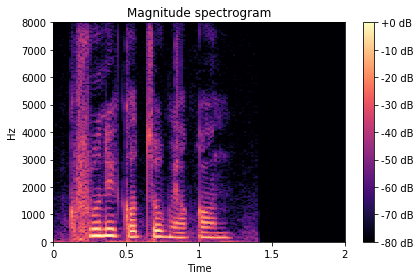

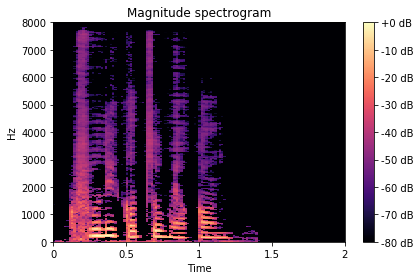

71.53711
46.768017


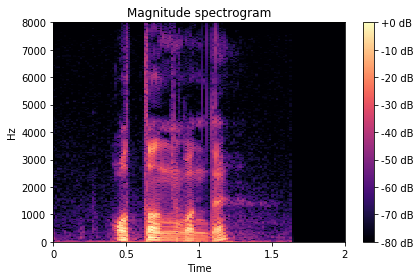

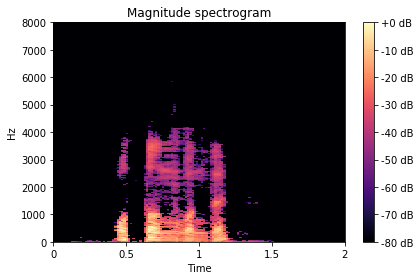

22.566032
13.328716


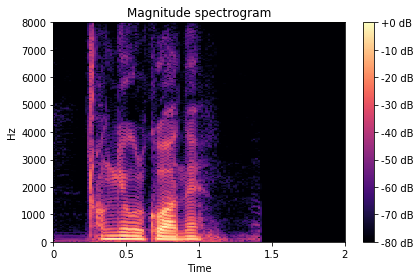

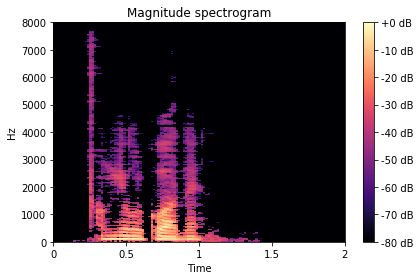

27.52974
17.600645


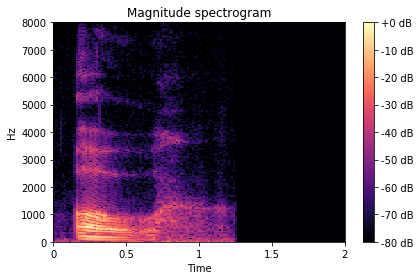

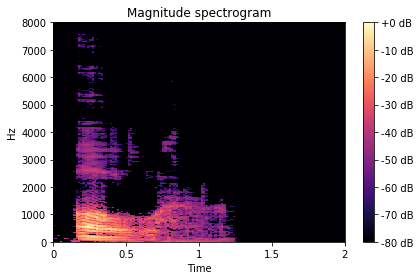

38.93978
24.181477


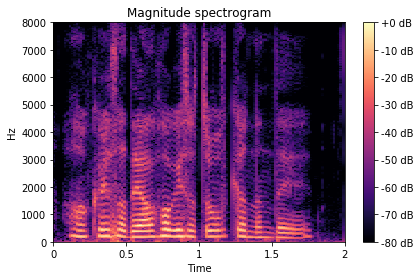

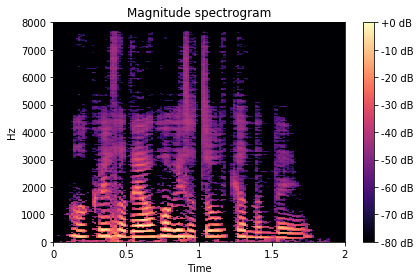

57.95244
33.834488


In [176]:
for each in dataset:
    pred_autoencoder = autoencoder(each)
    
    dl.specshow(each.numpy()[0], mel=False)
    dl.specshow(pred_autoencoder[0, :, :, 0], mel=False)
    print(np.max(each.numpy()))
    print(np.max(pred_autoencoder))
    pred_autoencoder = librosa.griffinlim(pred_autoencoder.numpy()[0, :, :, 0], hop_length=dl.hop_length, win_length=dl.win_length)
IPython.display.Audio(pred_autoencoder, rate=dl.sr)

In [ ]:
class MyModel(keras.models.Model):
    def __init__(self, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        
        self.act_fn = keras.layers.LeakyReLU()
        
        self.conv = [
            Conv2D(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same', activation=None, 
                   input_shape=[128, 128, 1]),
            self.act_fn,
            Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', activation=None),
            self.act_fn,
            Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same', activation=None),
            self.act_fn,
            Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), padding='same', activation=None),
            self.act_fn,
            keras.layers.Flatten(),
            Dense(units=output_size, activation=None), 
            self.act_fn
        ]
        
        self.rnn = [
            # 필요하다면, 마스킹 고려
            LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0,
                 unroll=False, use_bias=True, return_sequences=True, input_shape=[4, output_size]),
#             LSTM(units=2048, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0,
#                  unroll=False, use_bias=True, return_sequences=True)
        ]
        
        self.dconv = [
            Dense(units=8*8*64, activation=None),
            self.act_fn,
            keras.layers.Reshape([8, 8, 64]),
            # 16
            DConv(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same', activation=None),
            self.act_fn,
            # 32
            DConv(filters=16, kernel_size=(5, 5), strides=(2, 2), padding='same', activation=None),
            self.act_fn,
            # 64
            DConv(filters=8, kernel_size=(5, 5), strides=(2, 2), padding='same', activation=None),
            self.act_fn,
            # 128
            DConv(filters=1, kernel_size=(5, 5), strides=(2, 2), padding='same', activation=None),
            ReLU(max_value=100.0)
        ]
        
#         self.dconv = 
    
    def call(self, inputs, training=False):
        
        _x = inputs
        
        assert _x.shape[1:] == dl.mel_shape
            
        _x = self._conv_stack(_x)
        _x = self._rnn(_x)
        _x = self._dconv_concat(_x)
        
        logging.debug(f'MyModel: {_x.shape}')
        
        return _x
    
    def _rnn(self, x):
        for layer in self.rnn:
            x = layer(x)
        logging.debug(f'_rnn: {x.shape}')
        return x
    
    def _dconv_concat(self, x):
        _xs = []
        
        for i in range(dl.n_cnns):
            _x = tf.slice(x, begin=[0, i, 0], size=[-1, 1, -1])
            _x = tf.reshape(_x, shape=[-1, _x.shape[-1]])
            _x = self._dconv(_x)
            _x = tf.reshape(_x, shape=[-1, _x.shape[1], _x.shape[1]])
            _xs.append(_x)
        _x = tf.concat(_xs, -1)
        return _x
            
    def _dconv(self, x):
        for layer in self.dconv:
            x = layer(x)
        return x
    
    def _conv_stack(self, x):
        _xs = []
        
        for i in range(dl.n_cnns):
            _x = tf.slice(x, begin=[0, 0, i*dl.mel_shape[0]], size=[-1, dl.mel_shape[0], dl.mel_shape[0]])
            _x = tf.expand_dims(_x, axis=-1)
            _x = self._conv(_x)
            _xs.append(_x)
        _x = tf.stack(_xs, axis=1)
        return _x
    
    def _conv(self, _x):
        for layer in self.conv:
            _x = layer(_x)
            
        return _x

my_model = MyModel()
my_model.summary()

In [154]:
my_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5), loss=keras.losses.mean_squared_error)
my_model.fit(x_train, epochs=100)

DEBUG:root:_rnn: (None, 2, 256)


DEBUG:root:MyModel: (None, 128, 256)


Epoch 1/100


DEBUG:root:_rnn: (None, 2, 256)
DEBUG:root:MyModel: (None, 128, 256)
DEBUG:root:_rnn: (None, 2, 256)
DEBUG:root:MyModel: (None, 128, 256)


3/3 [==============================] - 3s 1s/step - loss: 13.8571
Epoch 2/100
3/3 [==============================] - 0s 88ms/step - loss: 17.5800
Epoch 3/100
3/3 [==============================] - 0s 85ms/step - loss: 17.5599
Epoch 4/100
3/3 [==============================] - 0s 90ms/step - loss: 17.4827
Epoch 5/100
3/3 [==============================] - 0s 92ms/step - loss: 17.5568
Epoch 6/100
3/3 [==============================] - 0s 88ms/step - loss: 17.4073
Epoch 7/100
3/3 [==============================] - 0s 86ms/step - loss: 17.4265
Epoch 8/100
3/3 [==============================] - 0s 83ms/step - loss: 17.3353
Epoch 9/100
3/3 [==============================] - 0s 83ms/step - loss: 17.2592
Epoch 10/100
3/3 [==============================] - 0s 87ms/step - loss: 17.2442
Epoch 11/100
3/3 [==============================] - 0s 83ms/step - loss: 16.9725
Epoch 12/100
3/3 [==============================] - 0s 83ms/step - loss: 17.4066
Epoch 13/100
3/3 [==============================] -